In [1]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec
import math
from mediapipe.framework.formats import landmark_pb2

# **Access using Using MediaPipe**

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
def media_pipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) 
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) 
    return image, results

In [4]:
def draw_land_marks(image, results):
    custom_pose_connections = list(mp_pose.POSE_CONNECTIONS)
    
    excluded_landmarks = [
        PoseLandmark.NOSE,
        PoseLandmark.LEFT_EYE_INNER,
        PoseLandmark.LEFT_EYE,
        PoseLandmark.LEFT_EYE_OUTER,
        PoseLandmark.RIGHT_EYE_INNER,
        PoseLandmark.RIGHT_EYE,
        PoseLandmark.RIGHT_EYE_OUTER,
        PoseLandmark.LEFT_EAR,
        PoseLandmark.RIGHT_EAR,
        PoseLandmark.MOUTH_LEFT,
        PoseLandmark.MOUTH_RIGHT,
        PoseLandmark.LEFT_HIP,
        PoseLandmark.RIGHT_HIP,
        PoseLandmark.LEFT_KNEE,
        PoseLandmark.RIGHT_KNEE,
        PoseLandmark.LEFT_ANKLE,
        PoseLandmark.RIGHT_ANKLE,
        PoseLandmark.LEFT_HEEL,
        PoseLandmark.RIGHT_HEEL,
        PoseLandmark.LEFT_FOOT_INDEX,
        PoseLandmark.RIGHT_FOOT_INDEX
    ]

    for landmark in excluded_landmarks:
        custom_pose_connections = [connection_tuple for connection_tuple in custom_pose_connections if landmark.value not in connection_tuple]

    mp_drawing.draw_landmarks(image, results.pose_landmarks, connections=custom_pose_connections)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_handmarks(image, results):   
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2),
                             ) 
      
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
     
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def extract_keypoints_normalize(results):
    shoulder_width = 1
    midpoint_shoulder_x = 1
    midpoint_shoulder_y = 1

    if results.pose_landmarks:
        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        
        midpoint_shoulder_x = (selected_pose_landmarks[0].x + selected_pose_landmarks[1].x) / 2
        midpoint_shoulder_y = (selected_pose_landmarks[0].y + selected_pose_landmarks[1].y) / 2

        shoulder_width = math.sqrt(pow((selected_pose_landmarks[1].x - selected_pose_landmarks[0].x) , 2) + pow((selected_pose_landmarks[1].y - selected_pose_landmarks[0].y) ,2))

        pose = np.array([[(res.x - midpoint_shoulder_x) / shoulder_width, (res.y - midpoint_shoulder_y) / shoulder_width] for res in selected_pose_landmarks]).flatten()
    else:
        pose = np.zeros(22*2)

        
    left_hand = np.array([[(res.x - midpoint_shoulder_x) / shoulder_width, (res.y - midpoint_shoulder_y) / shoulder_width] for res in  results.left_hand_landmarks]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
    right_hand = np.array([[(res.x - midpoint_shoulder_x) / shoulder_width, (res.y - midpoint_shoulder_y) / shoulder_width] for res in results.right_hand_landmarks]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
   
    return np.concatenate([pose, left_hand, right_hand])

def extract_keypoints(results):
    if results.pose_landmarks:
        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        pose = np.array([[res.x, res.y] for res in selected_pose_landmarks]).flatten()
    else:
        pose = np.zeros(22*2)
        
    left_hand = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
    right_hand = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
   
    return np.concatenate([pose, left_hand, right_hand])

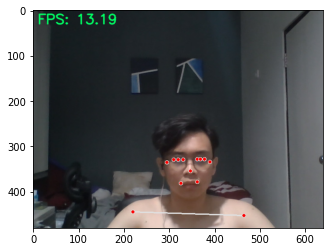

In [7]:
prev_frame_time = 0
new_frame_time = 0

cap = cv.VideoCapture(0) 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        new_frame_time = time.time()
        ret, frame = cap.read()
        fps = 1 / (new_frame_time - prev_frame_time)
        prev_frame_time = new_frame_time

        fps_text = "FPS: {:.2f}".format(fps)

        image, results = media_pipe_detection(frame, holistic)
        black_bg = np.zeros((frame.shape[0], frame.shape[1], frame.shape[2]))
        draw_land_marks(image, results)
        draw_land_marks(black_bg, results)

        cv.putText(image, fps_text, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 2, cv.LINE_AA)

        cv.imshow('Media Pipe Test', image)
        cv.imshow('Media Pipe Test-Black', black_bg)
        
        if(cv.waitKey(10) & 0xFF == ord(' ')):
            break

cap.release()
cv.destroyAllWindows()

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [8]:
def extract_keypoints(results):
    if results.pose_landmarks:
        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        pose = np.array([[res.x, res.y] for res in selected_pose_landmarks]).flatten()
    else:
        pose = np.zeros(22*2)

        
    left_hand = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
    right_hand = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
   
    return np.concatenate([pose, left_hand, right_hand])

# **Extract Keypoint Values**

In [9]:
def extract_keypoints(results):
    if results.pose_landmarks:
        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        pose = np.array([[res.x, res.y] for res in selected_pose_landmarks]).flatten()
    else:
        pose = np.zeros(22*2)

        
    left_hand = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
    right_hand = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
   
    return np.concatenate([pose, left_hand, right_hand])

In [10]:
def extract_coordinate(results):
    if results.pose_landmarks:
        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        for res in selected_pose_landmarks:
            x = res.x
            y = res.y
            # print(f"POSE LANDMARK x: {x}, y: {y}\n")
        
    if results.right_hand_landmarks:
        for res in results.right_hand_landmarks.landmark:
            x = res.x
            y = res.y
            # print(f"RIGHT HAND LANDMARK x: {x}, y: {y}\n")
    if results.left_hand_landmarks:
        for res in results.left_hand_landmarks.landmark:
            x = res.x
            y = res.y
            # print(f"LEFT HAND LANDMARK x: {x}, y: {y}\n")    

In [11]:
print(extract_coordinate(results))
print(extract_keypoints(results))
print(len(extract_keypoints(results)))

None
[0.72704786 0.94206971 0.344971   0.92501581 0.77641755 1.03277552
 0.24771273 1.18573236 0.74465859 1.05464184 0.34228119 1.09465384
 0.73417854 1.03766942 0.36887211 1.08324206 0.67987996 0.99253309
 0.38132048 1.04419279 0.67702234 0.99922544 0.38013852 1.05664206
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     